In [1]:
%matplotlib notebook
from emlib.iterlib import pairwise, window, flatten
from emlib import lib
import bpf4 as bpf
from emlib.music import timescale
from emlib import matplotting
from collections import Counter
from emlib.music import markov
from emlib.iterlib import *
import tabulate
import constraint
from math import *

In [28]:
def getSolutions(problem):
    solutions = []
    for sol in problem.getSolutionIter():
        slots = list(zip(*sorted(sol.items())))[1]
        solutions.append(slots)
    return solutions

def solveSlotsPerGroup(minGroups, maxGroups, minSlots, maxSlots):
    def solveSlots(numGroups):
        problem = constraint.Problem()
        variables = list(range(numGroups))
        values = list(range(minSlots, maxSlots+1))
        problem.addVariables(variables, values)
        for s0, s1 in window(variables, 2):
            problem.addConstraint(lambda s0, s1: abs(s0-s1) <= 1, [s0, s1])
        for s0, s1, s2 in window(variables, 3):
            problem.addConstraint(lambda s0, s1, s2: abs(s2-s0) <= 1, [s0, s1, s2])
            problem.addConstraint(lambda s0, s1, s2: not(s0==s1==s2), [s0, s1, s2])
        problem.addConstraint(lambda butlast, last: butlast >= last, [variables[-2], variables[-1]])
        if numGroups >= 4:
            for group in window(variables, 4):
                problem.addConstraint(lambda *ss: not(ss[0]==ss[1] and ss[2]==ss[3]), group)
        return getSolutions(problem)

    allsolutions = []
    for numGroups in range(minGroups, maxGroups+1):
        allsolutions.extend(solveSlots(numGroups))
    return allsolutions

In [43]:
def getIdxsPerGroup(slotsPerGroup):
    idx, out = 0, []
    for slots, nextslots in pairwise(slotsPerGroup):
        out.append([idx+j for j in range(slots)])
        idx += 1 if slots <= nextslots else slots - nextslots + 1
    out.append([idx+j for j in range(slotsPerGroup[-1])])
    return out

def buildGroups(slots, idxsPerGroup):
    return [[slots[idx] for idx in idxs] for idxs in idxsPerGroup]

def solveSection(sectionSecs, tempo, slotsPerGroup, minGroupDur, maxSlope, relError=0.1, minSlot=0.5):
    maxError = sectionSecs * relError
    numGroups = len(slotsPerGroup)
    sectionDur = sectionSecs * (tempo / 60)
    maxslot = sectionDur / numGroups
    values = timescale.default['values']
    values = [v for v in values if minSlot <= v <= maxslot]
    
    idxsPerGroup = getIdxsPerGroup(slotsPerGroup)
    idxsFlat = list(flatten(idxsPerGroup))
    numslots = max(idxsFlat) + 1
    slots = list(range(numslots))
    problem = constraint.Problem()
    problem.addVariables(slots, values)

    # ------------------ Constraints ------------------
    problem.addConstraint(lambda s0: s0==min(values), variables=[slots[0]])
    for s0, s1 in pairwise(slots):
        problem.addConstraint(lambda s0, s1: 1 <= s1/s0 <= 1.618, variables=[s0, s1])
    def constrSum(*slots):
        slotsSum = sum(slots[i] for i in idxsFlat)
        return abs(slotsSum - sectionDur) < maxError
    problem.addConstraint(constrSum)
    for group in idxsPerGroup:
        slotsInGroup = [slots[idx] for idx in group]
        problem.addConstraint(lambda *slots: sum(slots) >= minGroupDur, variables=slotsInGroup)
    for group0, group1 in pairwise(idxsPerGroup):
        problem.addConstraint(lambda s0, s1: s0 < s1, variables=[group0[-1], group1[-1]])
    for group in window(slots, 3):
        problem.addConstraint(lambda *slots: len(set(slots))>1, variables=group)
    problem.addConstraint(lambda s0, s1: s1/s0 < maxSlope, variables=[slots[0], slots[-1]])
    
    solutions = []
    for sol in problem.getSolutionIter():
        durs = list(zip(*sorted(sol.items())))[1]
        solutions.append((durs, buildGroups(durs, idxsPerGroup)))
    return solutions

In [47]:
minGroupDur = 0.5+0.5+0.75+1
possibleSlotsPerGroup = solveSlotsPerGroup(minGroups=4, maxGroups=5, minSlots=4, maxSlots=6)
allsolutions = []
for slotsPerGroup in possibleSlotsPerGroup:
    print(slotsPerGroup)
    solutions = solveSection(50, tempo=48, slotsPerGroup=slotsPerGroup, minGroupDur=minGroupDur, maxSlope=15)
    allsolutions.extend(solutions)
print("---------------------------> finished!")

(5, 6, 6, 5)
(6, 5, 6, 6)
(5, 5, 6, 5)
(6, 5, 6, 5)
(4, 4, 5, 4)
(5, 4, 5, 4)
(5, 4, 5, 5)
(5, 6, 5, 5)
(4, 5, 5, 4)
(6, 5, 5, 4)
(4, 5, 4, 4)
(6, 5, 6, 6, 5)
(6, 5, 6, 5, 5)
(5, 5, 6, 5, 5)
(4, 4, 5, 4, 4)
(5, 4, 5, 4, 4)
(5, 6, 5, 6, 5)
(6, 6, 5, 6, 5)
(5, 6, 5, 6, 6)
(6, 6, 5, 6, 6)
(4, 5, 5, 6, 5)
(6, 5, 5, 6, 5)
(5, 4, 5, 5, 4)
(5, 6, 5, 5, 4)
(5, 4, 4, 5, 4)
(4, 5, 4, 5, 5)
(5, 5, 4, 5, 5)
(4, 5, 4, 5, 4)
(5, 5, 4, 5, 4)


In [48]:
def rateSolution(solution, curve=None, groupCurve=None, groupCurveW=1, curveW=1, varianceW=1):
    slots, groups = solution
    variance = len(set(slots))/len(slots)
    ratings = {'variance': (variance, varianceW)}
    isbpf = lambda b: isinstance(b, bpf.BpfInterface)
    if curve is not None:
        relcurve = curve if isbpf(curve) else bpf.expon(0, 0, 1, 1, exp=curve)
        score = timescale.rateRelativeCurve(slots, relcurve)
        ratings['curve'] = (score, curveW)
    if groupCurve is not None:
        curve = groupCourve if isbpf(groupCurve) else bpf.expon(0, 0, 1, 1, exp=groupCurve)
        groupdurs = [sum(group) for group in groups]
        score = timescale.rateRelativeCurve(groupdurs, curve)
        ratings['groupcrv'] = (score, groupCurveW)
    weights = [weight for rate, weight in ratings.values()]
    sumweights = sum(weights)
    score = sqrt(sum((rate*weight/sumweights)**2 
                     for k, (rate, weight) in ratings.items()
                     if not k.startswith("_"))
                )
    return score, ratings

def prettyRatings(ratings):
    return " ".join(f"{k}={int(v*1000)}x{w}" for k, (v, w) in ratings.items())

In [49]:
def rater(sol):
    return rateSolution(sol, groupCurve=2, groupCurveW=5)

allsolutions.sort(reverse=True, key=lambda sol: rater(sol)[0])
table = []
for sol in allsolutions[:10]:
    rate, ratings = rater(sol)
    table.append((sol[1], rate, prettyRatings(ratings)))
lib.print_table(table)

"[[0.5, 0.5, 0.75, 1, 1.25], [0.5, 0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2], [1.25, 1.5, 2, 2.5, 4], [1.5, 2, 2.5, 4, 6]]",0.820618,variance=900x1 groupcrv=968x5
"[[0.5, 0.75, 0.75, 1, 1], [0.75, 1, 1, 1.25], [1, 1, 1.25, 2, 3], [1.25, 2, 3, 4.5], [2, 3, 4.5, 7]]",0.819709,variance=800x1 groupcrv=970x5
"[[0.5, 0.5, 0.75, 1, 1], [0.5, 0.75, 1, 1, 1.5], [1, 1, 1.5, 2], [1, 1.5, 2, 2.5, 4], [1.5, 2, 2.5, 4, 6]]",0.818862,variance=800x1 groupcrv=969x5
"[[0.5, 0.5, 0.75, 0.75, 1], [0.75, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 3], [1.25, 2, 3, 4.5], [2, 3, 4.5, 7]]",0.818636,variance=800x1 groupcrv=969x5
"[[0.5, 0.5, 0.75, 1, 1], [0.75, 1, 1, 1.25], [1, 1, 1.25, 2, 3], [1.25, 2, 3, 4.5], [2, 3, 4.5, 7]]",0.818454,variance=800x1 groupcrv=969x5
"[[0.5, 0.75, 0.75, 1, 1.25], [0.75, 0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2], [1.25, 1.5, 2, 2.5, 4], [1.5, 2, 2.5, 4, 6]]",0.818381,variance=900x1 groupcrv=965x5
"[[0.5, 0.5, 0.75, 1, 1.25], [0.5, 0.75, 1, 1.25, 1.5], [1, 1.25, 1.5, 2], [1.25, 1.5, 2, 3, 4], [1.5, 2, 3, 4, 6]]",0.817865,variance=900x1 groupcrv=964x5
"[[0.5, 0.5, 0.75, 0.75, 1], [0.5, 0.75, 0.75, 1, 1.5], [0.75, 1, 1.5, 2], [1, 1.5, 2, 2.5, 4], [1.5, 2, 2.5, 4, 6]]",0.817578,variance=800x1 groupcrv=967x5
"[[0.5, 0.5, 0.75, 1, 1], [0.5, 0.75, 1, 1, 1.25], [1, 1, 1.25, 2], [1, 1.25, 2, 2, 3], [1.25, 2, 2, 3, 4.5]]",0.817304,variance=700x1 groupcrv=970x5
"[[0.5, 0.75, 1, 1, 1.25], [1, 1, 1.25, 1.5], [1, 1.25, 1.5, 2, 2.5], [1.5, 2, 2.5, 4], [2, 2.5, 4, 6]]",0.817166,variance=900x1 groupcrv=963x5


In [70]:
# slot -> group -> sect
sectionSecs = 50
relError = 0.1
tempo = 48
slotsPerGroup = [4, 4, 5, 4, 5]
minSectionDur = (0.5+0.5+0.75+1)  # min dur de una seccion, en quarters
minslot = 0.5
maxSlope = 8

maxError = sectionSecs * relError
numGroups = len(slotsPerGroup)
sectionQs = sectionSecs * (tempo / 60)
maxslot = sectionQs/numGroups
values = timescale.default['values']
values = [v for v in values if minslot <= v <= maxslot]

def indicesPerGroup(slotsPerGroup):
    idx = 0
    out = []
    for slots, nextslots in pairwise(slotsPerGroup):
        out.append([idx+j for j in range(slots)])
        idx += 1 if slots <= nextslots else slots - nextslots + 1
    out.append([idx+j for j in range(slotsPerGroup[-1])])
    return out
    
groups = indicesPerGroup(slotsPerGroup)
print(groups)
distrflat = list(flatten(groups))
numslots = max(distrflat) + 1
slots = list(range(numslots))
problem = constraint.Problem()
problem.addVariables(slots, values)

# ------------------ Constraints ------------------
problem.addConstraint(lambda s0: s0==min(values), variables=[slots[0]])
for s0, s1 in pairwise(slots):
    problem.addConstraint(lambda s0, s1: 1 <= s1/s0 <= 1.618, variables=[s0, s1])
for group in groups:
    slotsInGroup = [slots[idx] for idx in group]
    problem.addConstraint(lambda *slots: sum(slots) >= minSectionDur, variables=slotsInGroup)
for group0, group1 in pairwise(groups):
    problem.addConstraint(lambda s0, s1: s0 < s1, variables=[group0[-1], group1[-1]])
for group in window(slots, 3):
    problem.addConstraint(lambda *slots: len(set(slots))>1, variables=group)
problem.addConstraint(lambda s0, s1: s1/s0 < maxSlope, variables=[slots[0], slots[-1]])
def constrSum(*slots):
    slotsSum = sum(slots[i] for i in distrflat)
    return abs(slotsSum - sectionQs) < maxError
problem.addConstraint(constrSum)

def buildGroups(slots):
    return [[slots[idx] for idx in group] for group in groups]

def getSolutions(problem):
    solutions = []
    for sol in problem.getSolutionIter():
        if not sol: continue
        pairs = list(sol.items())
        pairs.sort()
        durs = [v for k, v in pairs]
        solutions.append(durs)
    return solutions

isbpf = lambda b: isinstance(b, bpf.BpfInterface)

def rate(solution, *, curve=None, groupCurve=None, groupCurveW=1, curveW=1, varianceW=1):
    variance = len(set(solution))/len(solution)
    ratings = {'variance': (variance, varianceW)}
    groups = buildGroups(solution)
    if curve is not None:
        relcurve = curve if isbpf(curve) else bpf.expon(0, 0, 1, 1, exp=curve)
        score = timescale.rateRelativeCurve(solution, relcurve)
        ratings['curve'] = (score, curveW)
    if groupCurve is not None:
        curve = groupCourve if isbpf(groupCurve) else bpf.expon(0, 0, 1, 1, exp=groupCurve)
        groupdurs = [sum(group) for group in groups]
        score = timescale.rateRelativeCurve(groupdurs, curve)
        ratings['groupcrv'] = (score, groupCurveW)
    weights = [weight for rate, weight in ratings.values()]
    sumweights = sum(weights)
    score = sqrt(sum((rate*weight/sumweights)**2 for k, (rate, weight) in ratings.items()))
    ratings['score'] = score
    return ratings
    
solutions = getSolutions(problem)
rater = lambda s: rate(s, curve=2, groupCurve=2, curveW=1, varianceW=1, groupCurveW=4)
solutions.sort(reverse=True, key=lambda sol: rater(sol)['score'])
def infostr(info):
    return " ".join([f"{k}={v[0]:.3f}x{v[1]}={v[0]*v[1]:.3f}" for k, v in info.items() if k != "score"])

if solutions:
    solGroups = [buildGroups(s) for s in solutions[:10]]
    ratings = [rater(s) for s in solutions]
    rates = [r['score'] for r in ratings]
    durs = [sum(flatten(s)) * 60/tempo for s in solGroups]
    infos = [infostr(r) for r in ratings]
    groupdurs = [", ".join(str(sum(group)) for group in groups) for groups in solGroups]
    table = zip(solGroups, rates, durs, infos,groupdurs)
    
    lib.print_table(table)

[[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8, 9]]


"[[0.5, 0.75, 1, 1], [0.75, 1, 1, 1.25], [1, 1, 1.25, 1.5, 2], [1.25, 1.5, 2, 3], [1.5, 2, 3, 3.5, 3.5]]",0.667464,44.0625,variance=0.800x1=0.800 curve=0.907x1=0.907 groupcrv=0.954x4=3.818,"3.25, 4.0, 6.75, 7.75, 13.5"
"[[0.5, 0.75, 0.75, 1], [0.75, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2.5], [1.25, 2, 2.5, 3], [2, 2.5, 3, 3.5, 3.5]]",0.666777,46.875,variance=0.800x1=0.800 curve=0.880x1=0.880 groupcrv=0.955x4=3.820,"3.0, 3.75, 7.5, 8.75, 14.5"
"[[0.5, 0.5, 0.75, 1], [0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2.5], [1.25, 2, 2.5, 3], [2, 2.5, 3, 3.5, 3.5]]",0.666017,46.25,variance=0.800x1=0.800 curve=0.888x1=0.888 groupcrv=0.953x4=3.813,"2.75, 3.5, 7.5, 8.75, 14.5"
"[[0.5, 0.75, 0.75, 1], [0.75, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2], [1.25, 2, 2, 3], [2, 2, 3, 3.5, 3.5]]",0.666015,45,variance=0.700x1=0.700 curve=0.898x1=0.898 groupcrv=0.958x4=3.830,"3.0, 3.75, 7.0, 8.25, 14.0"
"[[0.5, 0.75, 0.75, 1], [0.75, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2], [1.25, 2, 2, 3], [2, 2, 3, 3, 3.5]]",0.665589,44.375,variance=0.700x1=0.700 curve=0.917x1=0.917 groupcrv=0.956x4=3.823,"3.0, 3.75, 7.0, 8.25, 13.5"
"[[0.5, 0.5, 0.75, 1], [0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2], [1.25, 2, 2, 3], [2, 2, 3, 3.5, 3.5]]",0.665562,44.375,variance=0.700x1=0.700 curve=0.906x1=0.906 groupcrv=0.956x4=3.826,"2.75, 3.5, 7.0, 8.25, 14.0"
"[[0.5, 0.75, 0.75, 1], [0.75, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2.5], [1.25, 2, 2.5, 3], [2, 2.5, 3, 3, 3.5]]",0.665443,46.25,variance=0.800x1=0.800 curve=0.898x1=0.898 groupcrv=0.952x4=3.807,"3.0, 3.75, 7.5, 8.75, 14.0"
"[[0.5, 0.75, 1, 1], [0.75, 1, 1, 1.25], [1, 1, 1.25, 2, 2.5], [1.25, 2, 2.5, 3], [2, 2.5, 3, 3.5, 3.5]]",0.664115,47.8125,variance=0.800x1=0.800 curve=0.870x1=0.870 groupcrv=0.951x4=3.805,"3.25, 4.0, 7.75, 8.75, 14.5"
"[[0.5, 0.5, 0.75, 1], [0.5, 0.75, 1, 1.25], [0.75, 1, 1.25, 2, 2.5], [1.25, 2, 2.5, 3], [2, 2.5, 3, 3, 3.5]]",0.664023,45.625,variance=0.800x1=0.800 curve=0.906x1=0.906 groupcrv=0.949x4=3.796,"2.75, 3.5, 7.5, 8.75, 14.0"
"[[0.5, 0.75, 1, 1], [0.75, 1, 1, 1.25], [1, 1, 1.25, 2, 2], [1.25, 2, 2, 3], [2, 2, 3, 3.5, 3.5]]",0.663083,45.9375,variance=0.700x1=0.700 curve=0.889x1=0.889 groupcrv=0.954x4=3.814,"3.25, 4.0, 7.25, 8.25, 14.0"


#### timescale.rateRelativeCurve([3.5, 4.5, 8, 12], bpf.expon(0, 0, 1, 1, exp=2), plot=True)

In [22]:
section_dur = 50
mindur = 6

solver = timescale.Solver(values=list(range(mindur, section_dur)), maxError=2, monotonous='up')
def constraints(problem, slots, config):
    problem.addConstraint(lambda s: s==mindur, variables=[slots[0]])
    problem.addConstraint(lambda s0, s1: s1/s0 < 3, [slots[0], slots[-1]])
        
solver.addConstraint(constraints)
rater = timescale.Rater(relcurve=1.3, curveWeight=4)
solutions = timescale.solve(solver, rater, section_dur, [4])
if not solutions:
    print("No hay soluciones!")
    1/0
timescale.report_solutions(solutions[:10])
sectionSolution = solutions[0]

numSubsections = len(sectionSolution.slots)
initialState = [4]
numslotsPerSubsection = genNumslots(numSubsections, initialState)
print("numslots per subsection: ", numslotsPerSubsection)


"[6, 12, 13, 17]",0.900748,variance: 1.000x1=1.000 curve: 0.874x4=3.497
"[6, 9, 16, 17]",0.900748,variance: 1.000x1=1.000 curve: 0.874x4=3.497
"[6, 10, 15, 17]",0.900748,variance: 1.000x1=1.000 curve: 0.874x4=3.497
"[6, 11, 14, 17]",0.900748,variance: 1.000x1=1.000 curve: 0.874x4=3.497
"[6, 10, 16, 17]",0.877324,variance: 1.000x1=1.000 curve: 0.844x4=3.375
"[6, 11, 15, 17]",0.877324,variance: 1.000x1=1.000 curve: 0.844x4=3.375
"[6, 12, 14, 17]",0.877324,variance: 1.000x1=1.000 curve: 0.844x4=3.375
"[6, 11, 16, 17]",0.854118,variance: 1.000x1=1.000 curve: 0.814x4=3.254
"[6, 12, 15, 17]",0.854118,variance: 1.000x1=1.000 curve: 0.814x4=3.254
"[6, 13, 14, 17]",0.854118,variance: 1.000x1=1.000 curve: 0.814x4=3.254


numslots per subsection:  [4, 4, 3, 4]


In [5]:
previous = None
rater = timescale.Rater(relcurve=1.5, curveWeight=2)
subsections = []
for i, slot in enumerate(sectionSolution.slots):
    numslots = numslotsPerSubsection[i]
    if previous is None:
        fixedslots = None
    else:
        offset = max(0, len(previous) - numslots)
        fixedslots=None if previous is None else {0: previous[1+offset], 1: previous[2+offset]}
    print("fixedslots", fixedslots)
    solver = timescale.Solver(
        maxIndexJump=2,
        maxRelativeError=0.1,
        fixedslots=fixedslots
    )
    solutions = timescale.solve(solver, rater, dur=slot, numslots=numslots, report=True)
    if not solutions:
        print(f"No hay solucion para {slot}, numslots: {numslots}")
        break
    measures = solutions[0].slots
    subsections.append(measures)
    previous = measures
    
print("subsections", subsections)

fixedslots None


"[1, 1, 1.5, 2]",0.876493,variance: 0.750x1=0.750 curve: 0.933x2=1.867
"[1, 1, 2, 2.5]",0.870447,variance: 0.750x1=0.750 curve: 0.925x2=1.850
"[1, 1.5, 1.5, 2.5]",0.858359,variance: 0.750x1=0.750 curve: 0.908x2=1.815
"[1, 1.5, 1.5, 2]",0.844993,variance: 0.750x1=0.750 curve: 0.889x2=1.777
"[1, 1, 1.5, 2.5]",0.837354,variance: 0.750x1=0.750 curve: 0.878x2=1.756
"[1, 1.5, 2, 2]",0.738931,variance: 0.750x1=0.750 curve: 0.733x2=1.467
"[1, 1, 2, 2]",0.737368,variance: 0.500x1=0.500 curve: 0.831x2=1.662
"[1.5, 1.5, 1.5, 2]",0.689337,variance: 0.500x1=0.500 curve: 0.767x2=1.533
"[1, 1.5, 1.5, 1.5]",0.545351,variance: 0.500x1=0.500 curve: 0.567x2=1.133
"[1.5, 1.5, 1.5, 1.5]",0.144338,variance: 0.250x1=0.250 curve: 0.000x2=0.000


fixedslots {0: 1, 1: 1.5}


"[1, 1.5, 1.5, 1.5, 2]",0.773498,variance: 0.600x1=0.600 curve: 0.847x2=1.694
"[1, 1.5, 1.5, 1.5, 1.5]",0.486912,variance: 0.400x1=0.400 curve: 0.525x2=1.050


fixedslots {0: 1.5, 1: 1.5}


"[1.5, 1.5, 2.5, 3.5]",0.876493,variance: 0.750x1=0.750 curve: 0.933x2=1.867
"[1.5, 1.5, 2.5, 3]",0.870447,variance: 0.750x1=0.750 curve: 0.925x2=1.850


fixedslots {0: 1.5, 1: 2.5}


"[1.5, 2.5, 3.5, 5]",0.965395,variance: 1.000x1=1.000 curve: 0.948x2=1.895
"[1.5, 2.5, 3, 4]",0.934523,variance: 1.000x1=1.000 curve: 0.900x2=1.800
"[1.5, 2.5, 3.5, 4]",0.892354,variance: 1.000x1=1.000 curve: 0.833x2=1.667
"[1.5, 2.5, 3.5, 3.5]",0.738931,variance: 0.750x1=0.750 curve: 0.733x2=1.467


fixedslots {0: 2.5, 1: 3.5}


"[2.5, 3.5, 3.5, 3.5, 3.5]",0.486912,variance: 0.400x1=0.400 curve: 0.525x2=1.050


subsections [[1, 1, 1.5, 2], [1, 1.5, 1.5, 1.5, 2], [1.5, 1.5, 2.5, 3.5], [1.5, 2.5, 3.5, 5], [2.5, 3.5, 3.5, 3.5, 3.5]]


In [10]:
def plotSection(subsections, sep=1):
    ax = matplotting.makeAxis()
    if isinstance(sep, int):
        seps = [sep] * (len(subsections) - 1)
    else:
        seps = sep
    x0, y0 = 0, 0
    height = 1
    for i, subsection in enumerate(subsections):
        matplotting.plotDurs(subsection, y0=y0, x0=x0, height=height, color=0.6, ax=ax)
        x0 += sum(subsection)
        if i < len(seps):
            sep = seps[i]
            matplotting.drawRect(ax, x0=x0, y0=y0, x1=x0+sep, y1=y0+height, color=0.2)
            x0 += sep
        

<IPython.core.display.Javascript object>


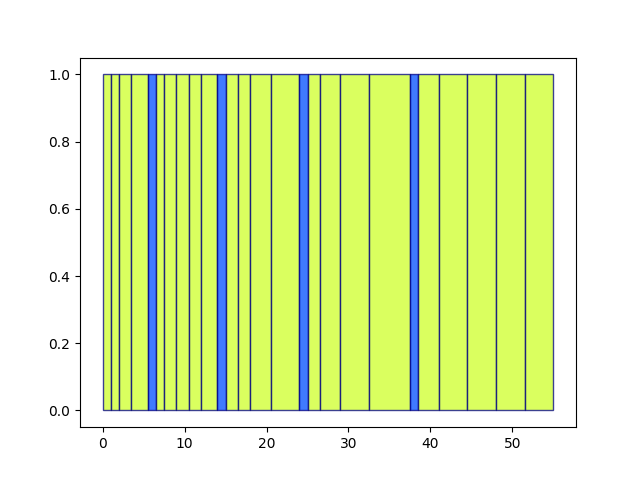

In [11]:
plotSection(subsections)